# eCommerce analytics

## Algorithmic Methods of Data Mining (Sc.M. in Data Science), Fall 2020

**Goal:** 
answer some research questions (RQs) that may help to discover and interpret meaningful patterns in data and eventually increase the number of sales

## Imports

In [1]:
# It's sufficient to use basic libraries such as pandas and matplotlib for the EDA
from IPython.display import Image
from shared import *

## Data retrival

Input data consists of one *.csv file (dataset) per months, for example

- 2019-Oct.csv for data collected in October 2019
- 2019-Nov.csv for data collected in November 2019

Each dataset is too big to be processed directly, there are a couple of approaches that can be applied to perform the analysis:

1. running a **bash script** so extract partial information which is essential to reply on a particular RQ, for example:

    for exploring number of purchases per category we may write a script ('*RQ2.sh*') which
     - creates a subset that contains only rows with event_type="purchase"
     - finds all unique categories present in the subset
     - loops through categories and for each category calculates number of lines present in the subset

    We started with that approach but it required different scripts for each single sub question of any RQ, it was time consuming and limited the vision of the whole picture


2. randomly **subsampling** dataset and perform analysis on smaller version
    
    can be implemented with pd.read_csv(..., **skiprows**=lambda x: ...)

    if we manage to extract data which represent the whole dataset well we may concentrate on the analysis of that cutted version of the dataset to make estimations
    
    the disadvantage of such an approach is that we can not make accurate evaluation and it's challenging to subsample the dataset to inherit at least the same statistical characteristics of the initial dataset in case we need to extrapolate the data to evaluate absolute values
 
3. splitting a file into **chunks** which allows to work with a dataset without overloading RAM
    
    In this case we don't need a powerful machine to run the code and we don't loose information by subsampling the dataset itself.
    
    There are two easy ways to work with chunks for a dataframe
    
    * by using **dash** library
    * by using **pandas** and modying default parameters for pd.read_csv()
    
    We chose to proceed by using pandas
    
As can be seen https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html there are a couple of parameters changing of which allows us to speed the operation up and also set up chunksize

* **usecols**: we specify only columns that are needed for a RQ
* **dtype**: we specify the format of data in each column to choose the min suffucient type representation 
* **engine**: C parser engine is obviously faster so we stick to it
* **na_filter**: if we switch off extra empty values handling it increases the performance
* **memory_map**: setting it to True removes I/O overhead as file object is directly mapped onto memory
* **chunksize**: sets chunk size of an iterable object
* **nrows**: while testing the code we may limit number of rows we consider 


In [2]:
# Datasets to be analyzed
df_labels

['2019-Oct', '2019-Nov']

In [3]:
# Display some rows to see the dataset structure
local_n_rows = 5
october_df = read_csv(
    df_label=default_file_label,
    parse_dates=['event_time'],
    date_parser=pd.to_datetime,
    size_mb=None,  # without chunks
    nrows=local_n_rows
)
october_df.head(local_n_rows)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [4]:
!python3 rq1.py --help

usage: rq1.py [-h] [-l DF_LABEL] [--aws AWS] [-mb SIZE_MB] [--nrows NROWS]
              {get_unique_events_types,get_complete_funnels_rate,most_repeated_operation,get_avg_n_of_views_for_view_cart_funnels,get_probability_that_if_in_cart_product_is_bought,get_avg_time_from_cart_to_purchase,get_avg_time_from_first_view_to_another_event}

Data analysis for RQ1

positional arguments:
  {get_unique_events_types,get_complete_funnels_rate,most_repeated_operation,get_avg_n_of_views_for_view_cart_funnels,get_probability_that_if_in_cart_product_is_bought,get_avg_time_from_cart_to_purchase,get_avg_time_from_first_view_to_another_event}

optional arguments:
  -h, --help            show this help message and exit
  -l DF_LABEL, --df-label DF_LABEL
  --aws AWS
  -mb SIZE_MB, --size-mb SIZE_MB
  --nrows NROWS


In [5]:
!python3 rq1.py get_unique_events_types -l '2019-Oct'


2019-Oct | got the following options as an event_type: ['cart', 'purchase', 'view']


In [6]:
!python3 rq1.py get_unique_events_types -l '2019-Nov'


2019-Nov | got the following options as an event_type: ['cart', 'purchase', 'view']


### First observations

1. As can be seen we have some **missing values** for category_code and brand. We may need to fill them in case we have other rows for the same category_id or drop them to exclude them from the analysis if there is not match found

2. There are solely 3 event_type categories, there is no information about an event such as 'removed from a cart'

# RQ1

A marketing **funnel** describes your customer’s journey with your e-commerce. 

It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond.

Suppose your funnel involves just three simple steps: 

1) view, 
2) cart, 
3) purchase. 


- **Which is the rate of complete funnels**?


- **What’s the operation users repeat more on average within a session?** Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).


- **How many times, on average, a user views a product before adding it to the cart?**


- **What’s the probability that products added once to the cart are effectively bought?**


- **What’s the average time an item stays in the cart before being removed?**


- **How much time passes on average between the first view time and a purchase/addition to cart?**

## Which is the rate of complete funnels? 

Theoretically if user viewed a product put in into the cart another day and purchased some other day the funnel is still complete. Session is changed every time a user come back to the store after a long pause, this column can be used for grouping.

There are "inconsistent" funnels in the dataset where after viewing a product person can buy it without putting into a cart -> **complete** funnels are the ones that lead to a **purchase**.

In [7]:
!python3 rq1.py get_complete_funnels_rate -l '2019-Oct' --nrows 100_000

.
2019-Oct | Complete funnels: 1549 out of 67767
2019-Oct | Rate of complete funnels: 2%


In [8]:
!python3 rq1.py get_complete_funnels_rate -l '2019-Oct'

......
2019-Oct | Complete funnels: 690372 out of 27783702
2019-Oct | Rate of complete funnels: 2%


As can be seen the data is pretty homogenious and we can calculate the rate on a much smaller subset

In [9]:
!python3 rq1.py get_complete_funnels_rate -l '2019-Nov' --nrows 100_000

.
2019-Nov | Complete funnels: 1352 out of 66169
2019-Nov | Rate of complete funnels: 2%


In [10]:
!python3 rq1.py get_complete_funnels_rate -l '2019-Nov' -mb 100

## What’s the operation users repeat more on average within a session? 
Produce a plot that shows the average number of times users perform each operation (view/etc).

.

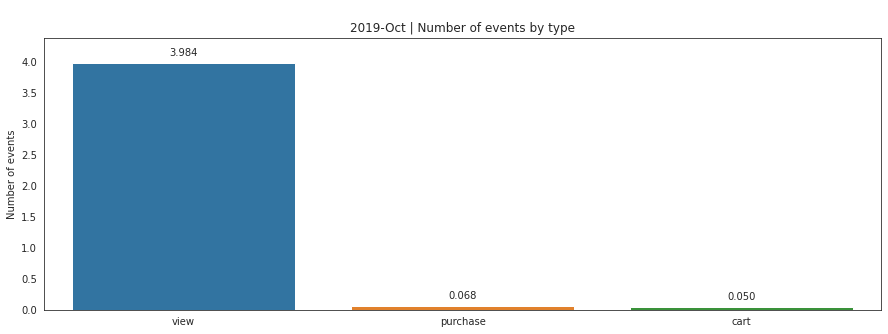

In [11]:
%run rq1.py most_repeated_operation -l '2019-Oct' --nrows 100_000

......

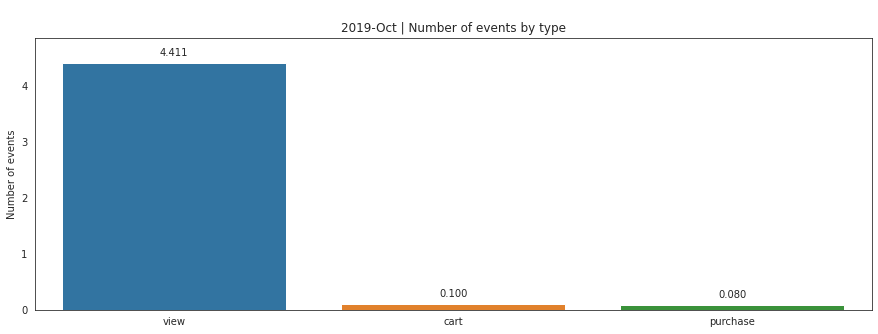

In [12]:
%run rq1.py most_repeated_operation -l '2019-Oct'

As can be seen:
 1. results are not drastically different for a small subset comparing to the whole dataset
 2. user performs approximatelly 4.4 views in average
 4. only around 80% of purchases are done after placing an item to the cart

In [13]:
%run rq1.py most_repeated_operation -l '2019-Nov' -mb 100

........

## How many times, on average, a user views a product before adding it to the cart?

In [14]:
!python3 rq1.py get_avg_n_of_views_for_view_cart_funnels -l '2019-Oct' --nrows 100_000

.
2019-Oct | A user views a product before adding it to the cart in average 1.984 times


In [15]:
!python3 rq1.py get_avg_n_of_views_for_view_cart_funnels -l '2019-Oct'

^C


In [16]:
!python3 rq1.py get_avg_n_of_views_for_view_cart_funnels -l '2019-Nov' -mb 100

In [17]:
for df_label in df_labels:
    get_avg_n_of_views_for_view_cart_funnels(df_label=df_label)

.......
2019-Oct | A user views a product before adding it to the cart in average 1.984 times
.......
2019-Nov | A user views a product before adding it to the cart in average 2.062 times


## What’s the probability that products added once to the cart are effectively bought?

In [18]:
!python3 rq1.py get_probability_that_if_in_cart_product_is_bought -l '2019-Oct' --nrows 100_000

.
2019-Oct | The probability that products added once to the cart are effectively bought 42%


In [19]:
!python3 rq1.py get_probability_that_if_in_cart_product_is_bought -l '2019-Oct'

In [20]:
!python3 rq1.py get_probability_that_if_in_cart_product_is_bought -l '2019-Nov' -mb 100

In [21]:
for df_label in df_labels:
    get_probability_that_if_in_cart_product_is_bought(df_label=df_label)

.......
2019-Oct | The probability that products added once to the cart are effectively bought 42%
.......
2019-Nov | The probability that products added once to the cart are effectively bought 39%


## What’s the average time an item stays in the cart before being removed?

As we're missing the information about the remove-from-cart events we'll calculate the average time an item stays in the cart before being purchased (which is also removing the item from the cart)


In [22]:
!python3 rq1.py get_avg_time_from_cart_to_purchase -l '2019-Oct' --nrows 100_000

.
2019-Oct | The average time an item stays in the cart before being purchased 0 days 00:57:33.991836735


In [23]:
!python3 rq1.py get_avg_time_from_cart_to_purchase -l '2019-Oct'

In [24]:
!python3 rq1.py get_avg_time_from_cart_to_purchase -l '2019-Nov' -mb 100

In [25]:
for df_label in df_labels:
    get_avg_time_from_cart_to_purchase(df_label=df_label)

.......
2019-Oct | The average time an item stays in the cart before being purchased 0 days 01:34:35.236607143
.......
2019-Nov | The average time an item stays in the cart before being purchased 0 days 00:27:44.678756477


## How much time passes on average between the first view time and a purchase/addition to cart?

In [26]:
!python3 rq1.py get_avg_time_from_first_view_to_another_event -l '2019-Oct' --nrows 100_000

.
2019-Oct | The average time between the first view time and a purchase/addition to cart 0 days 00:48:14.000623830


In [27]:
!python3 rq1.py get_avg_time_from_first_view_to_another_event -l '2019-Oct'

In [28]:
!python3 rq1.py get_avg_time_from_first_view_to_another_event -l '2019-Nov' -mb 100

In [29]:
for df_label in df_labels:
    get_avg_time_from_first_view_to_another_event(df_label=df_label)

.......
2019-Oct | The average time between the first view time and a purchase/addition to cart 0 days 02:00:11.825112108
.......
2019-Nov | The average time between the first view time and a purchase/addition to cart 0 days 01:40:49.862692565


In [30]:
for df_label in df_labels:
    get_avg_time_from_first_view_to_another_event(df_label=df_label)  # if we consider only the first event

.......
2019-Oct | The average time between the first view time and a purchase/addition to cart 0 days 02:04:35.807580175
.......
2019-Nov | The average time between the first view time and a purchase/addition to cart 0 days 01:37:42.424810353


# RQ2

 - **What are the categories of the most trending products overall?** 
   
   For each month visualize this information through a plot showing the number of sold products per category.  
 
- **Plot the most visited subcategories.**


- **What are the 10 most sold products per category?**

## What are the categories of the most trending products overall?

The question is misleading as categories of the most trending products may be different from the most trending categories themselves. Considering the side question asking to plot number of sold products per category, we may concentrate on categories themselves.

We consider a category to be trending if its products are selling out well (the more purchases - the trendier)
 
Category - is the first value before . separator, the rest are sub-categories

.......................................................

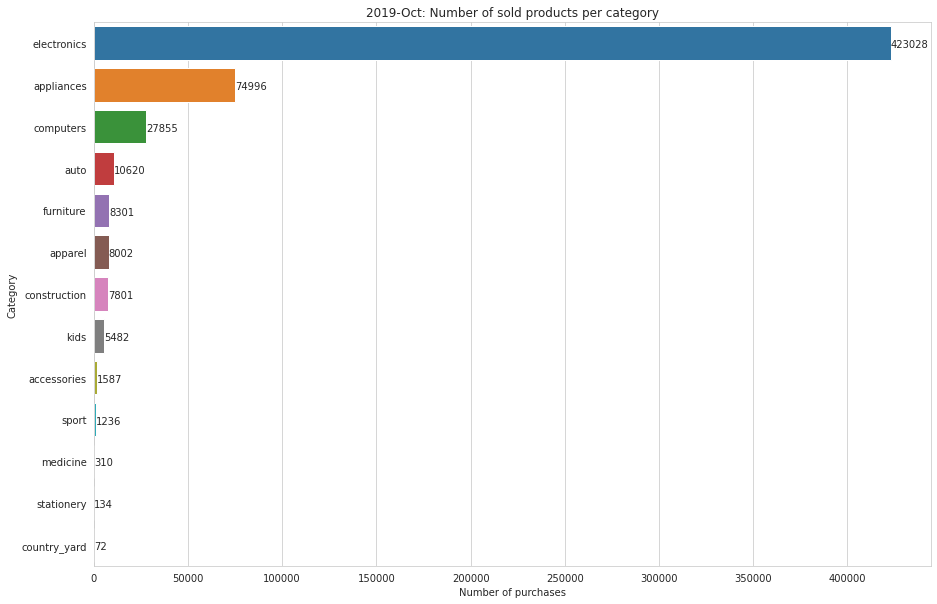

......................................................................................

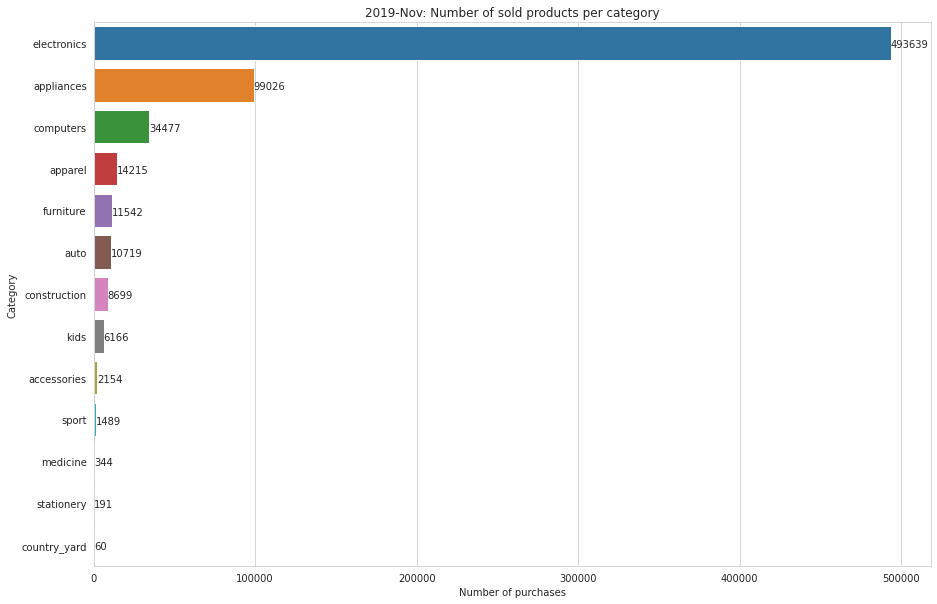

In [31]:
%run rq2.py get_most_trending_products -l '2019-Oct' -mb 100
%run rq2.py get_most_trending_products -l '2019-Nov' -mb 100

Using a script to perform the same data extraction can be beneficial, we could do the extraction once with a script and perform visualization in Python any time we need

Indeed that can be more efficient but at the same time it takes time and effort to design proper scripts, and also requires some bash comprehension 

In [32]:
!bash RQ2.sh

2019-Nov.csv
2019-Oct.csv


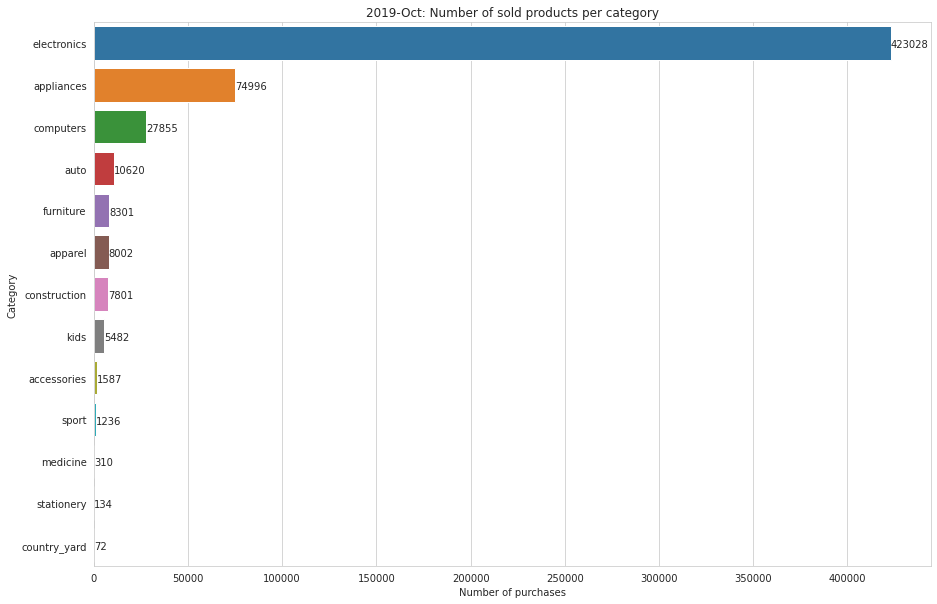

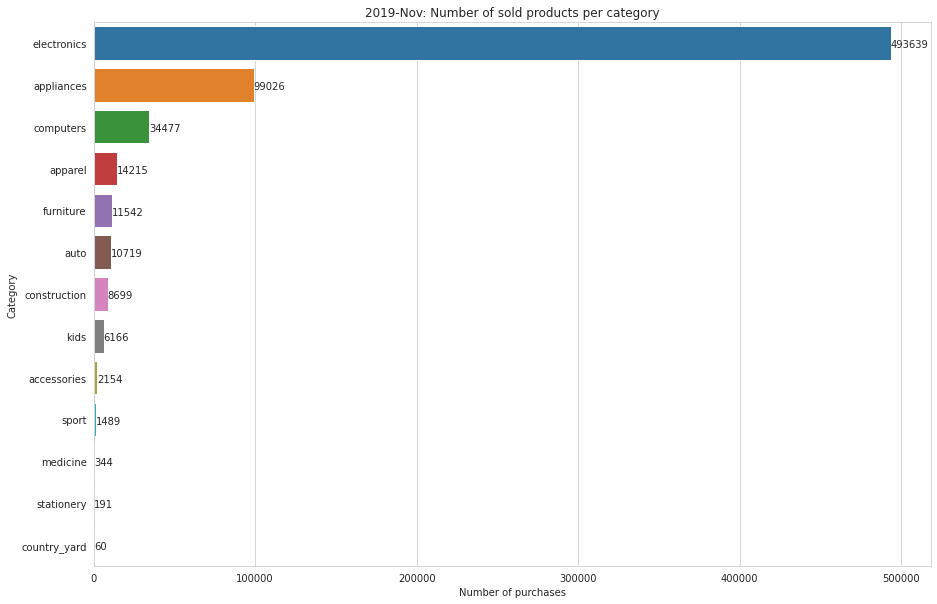

In [33]:
%run rq2.py get_most_trending_products_with_bash -l '2019-Oct'
%run rq2.py get_most_trending_products_with_bash -l '2019-Nov'

As can be seen, **the results are the same for both approaches** but with bash parsing is much faster and if we keep '\*.csv.purchases-per-category.csv' results can be reproduced in less than a second

## Plot the most visited subcategories

We assume that each subcategory is composed by combination of the category and all the nested (sub) categories
 
Category - is the first value before . separator, the rest are sub-categories

For the analysis after categories we're the most interested in the first subcategory, so we'll consider it (any number of subcategories can be added as an argument of the function, there are max 3 observed subcategories in the datasets)

.......................................................

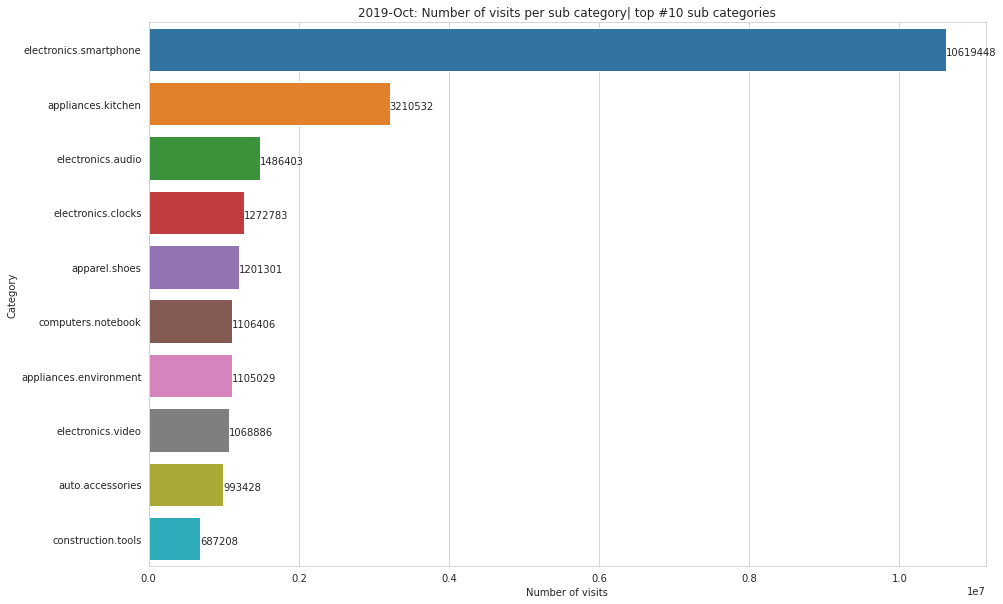

......................................................................................

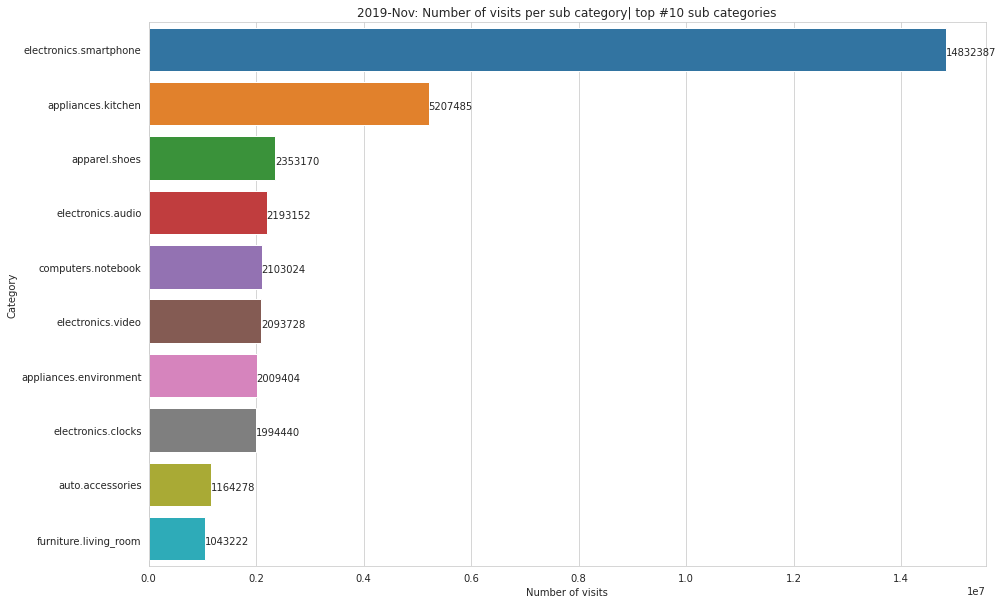

In [34]:
%run rq2.py get_most_visited_sub_categories -l '2019-Oct' -mb 100
%run rq2.py get_most_visited_sub_categories -l '2019-Nov' -mb 100

## What are the 10 most sold products per category?

Category - is the first value before . separator, the rest are sub-categories

In [35]:
!python3 rq2.py get_categories -l '2019-Oct'
!python3 rq2.py get_categories -l '2019-Nov' -mb 100

.......................................................
2019-Oct | Categories: 
appliances
furniture
computers
electronics
apparel
construction
auto
kids
sport
accessories
medicine
stationery
country_yard
......................................................................................
2019-Nov | Categories: 
electronics
appliances
computers
furniture
apparel
construction
auto
accessories
kids
sport
medicine
country_yard
stationery


In [36]:
%run -i rq2.py get_most_sold_products_per_category --nrows 10_000

Please enter a category (and optionally file label, comma separated): electronics
.
2019-Oct | The 10 most sold products per 'electronics' are: 1004856, 1004750, 1004833, 1004246, 1002524, 4804295, 1004870, 1004767, 1005104, 4804055


In [37]:
%run -i rq2.py get_most_sold_products_per_category

Please enter a category (and optionally file label, comma separated): electronics, 2019-Oct
......
2019-Oct | The 10 most sold products per 'electronics' are: 1004856, 1004767, 1004833, 1005115, 4804056, 1004870, 1002544, 1004249, 1004836, 1005105


In [38]:
%run -i rq2.py get_most_sold_products_per_category --nrows 100_000 -mb 100

Please enter a category (and optionally file label, comma separated): electronics, 2019-Nov
.
2019-Nov | The 10 most sold products per 'electronics' are: 1004856, 1004767, 1005115, 1004249, 1004833, 1004870, 4804056, 1002544, 1004739, 1005105


In [39]:
%run -i rq2.py get_most_sold_products_per_category -mb 100

Please enter a category (and optionally file label, comma separated): electronics, 2019-Nov
......................................................................................
2019-Nov | The 10 most sold products per 'electronics' are: 1004856, 1004767, 1005115, 4804056, 1004833, 1002544, 1004870, 1005100, 1004249, 1005105


Surprisingly the most sold product per category can be identified based on just a small subset of observations (fortunatelly we have the dataset sorted by the event time and even observing shorter but sufficiently long period of time we can get essential information to make evaluation

Also as can be seen the product that is sold the most in electronics category remains the same for both October and November

# RQ3

For each category, what’s the brand whose prices are higher on average?
 

 - Write a function that asks the user a category in input and returns a **plot indicating the average price of the products sold by the brand.**
 
 
 - **Find, for each category, the brand with the highest average price.** 
 
 
Return all the results in ascending order by price.

## Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.

Please enter a category (and optionally file label, comma separated): electronics
.

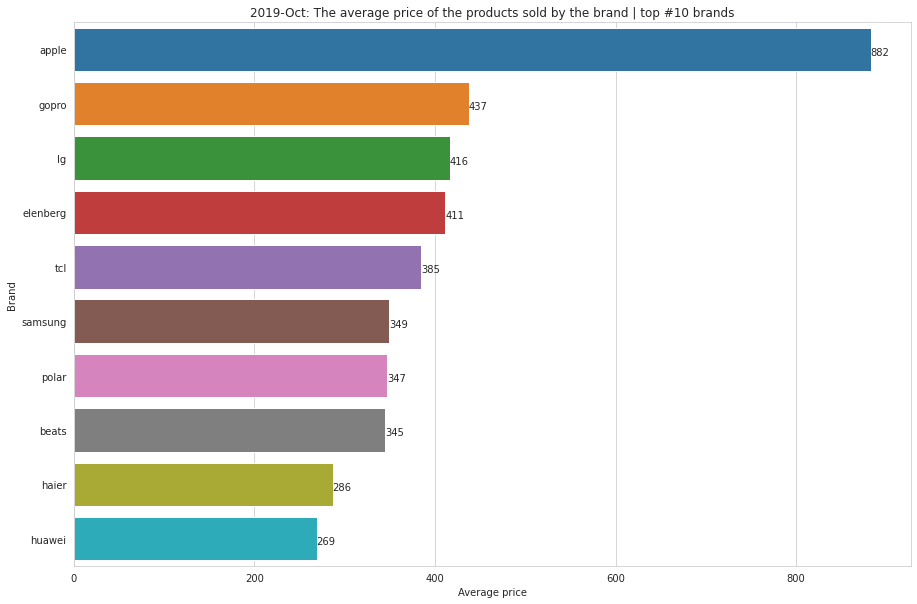

In [40]:
%run -i rq3.py get_brands_avg_prices_per_category -mb 100 --nrows 100_000

In [42]:
%run -i rq3.py get_brands_avg_prices_per_category -mb 100

Please enter a category (and optionally file label, comma separated): electronics, 2019-Nov
.

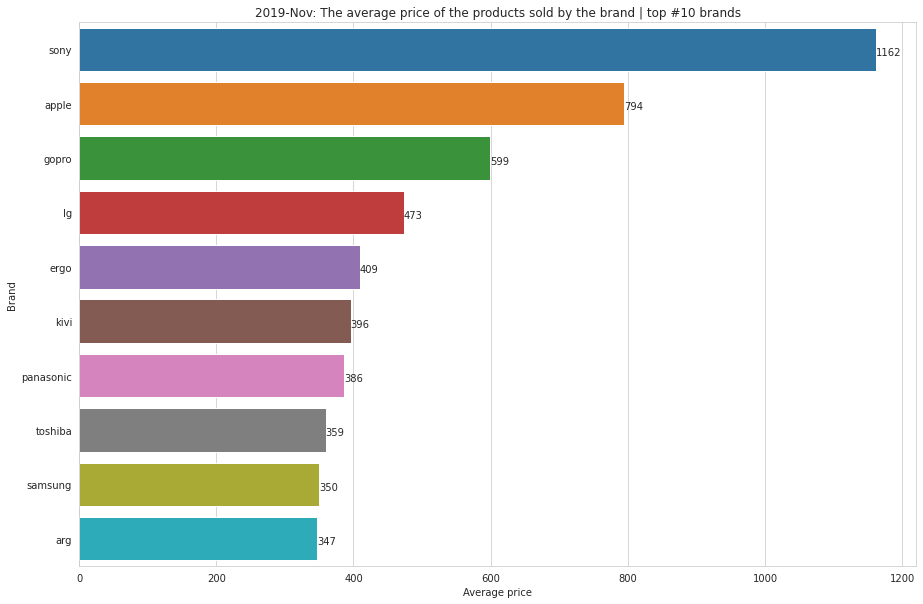

In [43]:
%run -i rq3.py get_brands_avg_prices_per_category -mb 100 --nrows 100_000

In [44]:
%run -i rq3.py get_brands_avg_prices_per_category -mb 100

## Find, for each category, the brand with the highest average price.

In the previous question we were considering only purchases, here that was not explicitly stated, so we're considering all available products (even those which have not been sold)

In [45]:
%run -i rq3.py get_brand_with_highest_prices_per_category -mb 100 --nrows 500_000

Please enter a category (and optionally file label, comma separated): electronics
.
2019-Oct | For category 'electronics' the brands 'rado', 'oris', 'longines', 'blg', 'takamine', 'versace', 'electro-voice', 'vivitek', 'microsoft', 'biema' got the highest prices on average


In [46]:
%run -i rq3.py get_brand_with_highest_prices_per_category -mb 100 --nrows 500_000

Please enter a category (and optionally file label, comma separated): electronics, 2019-Nov
.
2019-Nov | For category 'electronics' the brands 'takamine', 'rado', 'longines', 'oris', 'kef', 'versace', 'neumann', 'vivitek', 'alpina', 'nikon' got the highest prices on average


In [47]:
%run -i rq3.py get_brand_with_highest_prices_per_category -mb 100

Please enter a category (and optionally file label, comma separated): electronics
.......
2019-Oct | For category 'electronics' the brands 'rado', 'oris', 'longines', 'blg', 'kef', 'versace', 'takamine', 'vivitek', 'jaguar', 'nikon' got the highest prices on average


In [48]:
%run -i rq3.py get_brand_with_highest_prices_per_category -mb 100

As can be clearly seen, **the most expensive** (regarding the average products prices) **brands are not selling as frequent as brands with lower average price**. 

Considering price along with sales, we could get more representative statistics and identify the most successful brands based on profit they are making in their price group.

# RQ4

How much does each brand earn per month? 

Write a function that given the name of a **brand** in input returns, for each month, its **profit**. Is the average price of products of different brands significantly different?

Using the function you just created, find **the top 3 brands that have suffered the biggest losses in earnings** between one month and the next, specifing bothe the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).

In [49]:
!bash RQ4.sh

2019-Nov.csv
2019-Oct.csv


we have got the global revenue of each brand 
and also the revenue of sigle month

In [50]:
nov_rq4 = pd.read_csv('datasets/2019-Nov.csv.rq4.csv')

In [51]:
octo_rq4 = pd.read_csv('datasets/2019-Oct.csv.rq4.csv')

In [52]:
tot_rq4 = pd.concat([octo_rq4,nov_rq4]) #about a minute

In [53]:
global_revenue    = tot_rq4[tot_rq4['event_type'] == 'purchase'].groupby('brand').price.sum()
october_revenue   = octo_rq4[octo_rq4['event_type'] == 'purchase'].groupby('brand').price.sum()
november_revenue  = nov_rq4[nov_rq4 ['event_type'] == 'purchase'].groupby('brand').price.sum()

In [54]:
len(global_revenue) == len(october_revenue) #not every brand present in the global are also present 
                                            #in the october or in november

False

november_revenue['a-derma']
we noted that there are some missing values

In [55]:
#global revenues for each brand:
global_revenue

brand
a-case       1083.58
a-derma        12.36
a-elita         8.49
a-mega       1940.15
aardwolf      219.10
              ...   
zotac        2185.57
zte         22528.00
zubr        16647.05
zuru           64.20
zvezda         11.97
Name: price, Length: 2713, dtype: float64

### RQ4.1

Write a function that given the name of a brand in input returns, for each month, its profit.

In [56]:
def income():
    
    brand = input('Input your favourit brand!')
    try:
        print('During October the brand',brand,'gained', round(october_revenue[brand],3))
    except Exception as e:
        print(f"No sales in October")
    
    try:
        print('During November the brand',brand,'gained', round(november_revenue[brand],3))
    except Exception as e:
        print(f"No Sales in November")

In [57]:
income()

Input your favourit brand!apple
During October the brand apple gained 111209268.82
During November the brand apple gained 127512524.88


### RQ4.2
Is the average price of products of different brands significantly different?
average price of product for each brand
we take a subset to obtain a faster code
after taking a subset, we group by brand and take the mean of price of each brand

In [58]:
subRQ4 = tot_rq4
avg_price_df = subRQ4[['brand','price']].dropna()
avg_price_df.head()

,brand,price
0,shiseido,35.79
1,aqua,33.20
3,lenovo,251.74
4,apple,1081.98
5,pulser,908.62


In [59]:
# description of the distribution of every brand 
avg_price_for_all_brand = avg_price_df.groupby(['brand']).describe()
avg_price_for_all_brand.head()

price                                                          
            count       mean        std    min    25%    50%    75%     max
brand                                                                      
a-case    19503.0  12.142794  26.637865   1.21   4.09   4.61   7.31  154.44
a-derma     729.0  13.906379   4.966100   5.15   9.78  12.48  16.47   22.39
a-elita     521.0  45.051727  31.722959   8.49   8.49  73.28  73.28   73.28
a-mega     1384.0  84.286734  53.504038  25.74  56.05  66.93  87.52  218.80
aardwolf    526.0  39.057414  25.503133   8.98  23.30  25.35  78.90   84.43

In [60]:
avg_price_for_all_brand['price']['count']

brand
a-case                19503.0
a-derma                 729.0
a-elita                 521.0
a-mega                 1384.0
aardwolf                526.0
                       ...   
zwerg                    18.0
zwilling                149.0
zwillingjahenckels     1136.0
zx                        9.0
zyxel                   760.0
Name: count, Length: 4302, dtype: float64

In [61]:
avg_price_for_brand = avg_price_df.groupby(['brand']).mean().describe()
avg_price_for_brand

,price
count,4302.000000
mean,173.747521
std,279.311420
min,0.970000
25%,25.804224
50%,68.732001
75%,195.247329
max,2533.238401


the number speak clear:
the mean's range is more than 2500
the max revenue is 2533 which is equival to the 2500 % of the min, just 0.97

### RQ4.3

Using the function you just created, find the top 3 brands that have suffered the biggest losses 
in earnings between one month and the next, specifing 
both the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).

In [62]:
losses_for_month = november_revenue.divide(october_revenue).dropna()
rank_losses = losses_for_month.sort_values(ascending = True)
list_of_brand = rank_losses.axes[0].tolist()
list_of_brand[0]

'jonnesway'

In [63]:
rank_losses

brand
jonnesway       0.033757
sunfull         0.040000
evga            0.041003
illumico        0.042754
ventura         0.049566
                ...     
asm           108.001142
pinskdrev     115.462580
dinastia      133.585617
delta         774.262125
melitta      1936.160000
Name: price, Length: 1756, dtype: float64

In [64]:
def worst_brand():
    losses_for_month = november_revenue.divide(october_revenue).dropna()
    rank_losses = losses_for_month.sort_values(ascending = True)
    list_of_brand = rank_losses.axes[0].tolist()
    print(list_of_brand[0],' lost ',round(1-rank_losses[0],2)*100,'% beetween October and November\n',
          list_of_brand[1],' lost ',round(1-rank_losses[1],2)*100,'% beetween October and November\n',
          list_of_brand[2],' lost ',round(1-rank_losses[2],2)*100,'% beetween October and November', sep = '')
worst_brand()

jonnesway lost 97.0% beetween October and November
sunfull lost 96.0% beetween October and November
evga lost 96.0% beetween October and November


# RQ5

In [65]:
!bash RQ5.sh

2019-Nov.csv
2019-Oct.csv


In [66]:
nov_rq5 = pd.read_csv('datasets/2019-Nov.csv.rq5.csv')

In [67]:
octo_rq5 = pd.read_csv('datasets/2019-Oct.csv.rq5.csv')

In [68]:
tot_rq5 = pd.concat([octo_rq5,nov_rq5]) #about a minute

In [69]:
subRQ5 = tot_rq5
views =  subRQ5[subRQ5['event_type']=='view']

In [70]:
#extracting first and last rows
subRQ5.iloc[[0, -1]]
subRQ5.head()

,event_time,event_type,product_id,category_id
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655


In [71]:
# through datetimeIndex we devide all events into bands
# *** REQUIRES MUCH TIMES ***
times = pd.DatetimeIndex(subRQ5.event_time)

In [72]:
#we count events happen for hour
count_per_hour = subRQ5.groupby([times.hour]).count()

In [73]:
#we take just a column because one it s enough
product_view_per_hour = count_per_hour['product_id']

In [74]:
sorted_views_per_hour = product_view.sort_values(ascending=False)

from the output we can notice that the hour with the highest 
numner of viewers is the 17th (python starts from 0 => 16+1)
it means the from 4 to 5 pm we have the highest number of visitors
this info could be useful when for example a brand wants to put 
its add, it can chooses the best hours
but it s means, that of course, it will pay more than a ads in 
other hours.

now let s do the a slightly different thing 
to find the best day for our online market!

In [75]:
count_per_day = subRQ5.groupby([times.day]).count()

In [76]:
count_per_day
# day of the month
# like expected 31th data is lower cause november hasn't 31 days

,event_time,event_type,category_code,product_id
event_time,,,,
1,2689605,2689605,1827091,2689605
2,2746866,2746866,1875385,2746866
3,2695077,2695077,1855443,2695077
4,3210318,3210318,2188665,3210318
5,3047583,3047583,2038214,3047583
6,3013200,3013200,2018128,3013200
7,2997364,2997364,1984888,2997364
8,3267035,3267035,2141771,3267035
9,3225449,3225449,2128405,3225449


In [77]:
# day of the month
# like expected 31th data is lower cause november hasn't 31 days
count_per_day_of_week = product_view.dt.dayofweek

In [78]:
count_per_week

,event_time,event_type,category_code,product_id
event_time,,,,
40,7628784,7628784,5246993,7628784
41,9817094,9817094,6389277,9817094
42,10367408,10367408,7240363,10367408
43,9691064,9691064,6702619,9691064
44,9513086,9513086,6466256,9513086
45,12716909,12716909,8490112,12716909
46,28204600,28204600,19385147,28204600
47,11849199,11849199,7785131,11849199
48,10162599,10162599,6831065,10162599


In [79]:
count_per_day_of_week = subRQ5.groupby([times.dayofweek]).count()
#counting for day of week

In [80]:
count_per_day_of_week

,event_time,event_type,category_code,product_id
event_time,,,,
0,12739141,12739141,8562471,12739141
1,13890118,13890118,9283918,13890118
2,13713060,13713060,9206075,13713060
3,14582640,14582640,9915507,14582640
4,18814507,18814507,12870638,18814507
5,18859791,18859791,12882288,18859791
6,17351486,17351486,11816066,17351486


In [81]:
product_view_per_day_of_week = count_per_day_of_week['product_id']


In [82]:
sorted_views_per_day_of_week = product_view_per_day_of_week.sort_values(ascending=False)
sorted_views_per_day_of_week.head(1)

event_time
5    18859791
Name: product_id, dtype: int64

according to the website 
https://pythontic.com/datetime/date/weekday
5 corresponds to Saturday
so saturday is the day when the store has the highest number of views

# RQ6

In [83]:
!bash RQ6.sh

2019-Nov.csv
2019-Oct.csv


In [84]:
nov_rq6 = pd.read_csv('datasets/2019-Nov.csv.rq6.csv')

In [85]:
octo_rq6 = pd.read_csv('datasets/2019-Oct.csv.rq6.csv')

In [86]:
tot_rq6 = pd.concat([octo_rq6,nov_rq6]) #about a minute

In [87]:
tot_rq6.head()

,event_type,product_id,category_code,user_id
0,view,44600062,NaN,541312140
1,view,3900821,appliances.environment.water_heater,554748717
2,view,17200506,furniture.living_room.sofa,519107250
3,view,1307067,computers.notebook,550050854
4,view,1004237,electronics.smartphone,535871217


In [88]:
subRQ6 = tot_rq6
subRQ6.head()

,event_type,product_id,category_code,user_id
0,view,44600062,NaN,541312140
1,view,3900821,appliances.environment.water_heater,554748717
2,view,17200506,furniture.living_room.sofa,519107250
3,view,1307067,computers.notebook,550050854
4,view,1004237,electronics.smartphone,535871217


obtaining the number of product sold:
by taking only rows about purchasing
and at the end we count them (.shape[0])
shape[0] are the rows of the dataset where the event is equal to purchase
so it rapresents the product sold

In [89]:
df_prod_sold =  subRQ6[subRQ6['event_type']=='purchase']
prod_sold = df_prod_sold.shape[0]
prod_sold

1659788

in a similar way we calculate the number of user:
this time we group by 'user_id' so we obtain the exact users's number
we extract that number by the command shape[0] (number of rows)

In [90]:
users = subRQ6.groupby('user_id').product_id.count().shape[0]
users

5316649

In [91]:
#finally we calculate the actual purchase rate value
purchase_rate = prod_sold/users
round(purchase_rate,4)

0.3122

In [92]:
#same think of before
df_views = subRQ6[subRQ6['event_type']=='view']
views = df_views.shape[0]

In [93]:
#conversion rate calculated by following the previous formula
conversion_rate = purchase_rate / views
conversion_rate

2.992144008055359e-09

In [94]:
#dropping nas values for both dataframe
df_views = df_views.dropna()
df_prod_sold = df_prod_sold.dropna()

In [95]:
#purchase rate of each category
df_prod_sold['category_code'] = [el.split('.')[0] for el in list(df_prod_sold['category_code']) if type(el) == str]

In [96]:
number_of_sales = df_prod_sold.groupby('category_code').product_id.count()
number_of_sales

category_code
accessories       3741
apparel          22217
appliances      174022
auto             21339
computers        62332
construction     16500
country_yard       132
electronics     916667
furniture        19843
kids             11648
medicine           654
sport             2725
stationery         325
Name: product_id, dtype: int64

In [97]:
# obtaining number of users for each categories
# first step: grouping for categories subRQ6
grouped_subRQ6 = subRQ6.groupby("category_code")

In [98]:
#now we want to extract the number of unique users for each category
user_of_each_cat = grouped_subRQ6.agg({"user_id": "nunique"})
user_of_each_cat.iloc[:,0]

category_code
accessories.bag         102249
accessories.umbrella      3853
accessories.wallet       19867
apparel.belt              2941
apparel.costume         145585
                         ...  
sport.ski                 4769
sport.snowboard           6137
sport.tennis              3370
sport.trainer            24029
stationery.cartrige       5690
Name: user_id, Length: 129, dtype: int64

In [99]:
#converting into a series
series_of_unique_users = user_of_each_cat.iloc[:,0]

In [100]:
#calculating the purchase rate => 
# number of product sold for each catogory / number of unique user for each category
purchase_rate_for_cat = number_of_sales.divide(series_of_unique_users)
round(purchase_rate_for_cat,4).sort_values(ascending=False)


category_code
accessories            NaN
accessories.bag        NaN
accessories.umbrella   NaN
accessories.wallet     NaN
apparel                NaN
                        ..
sport.snowboard        NaN
sport.tennis           NaN
sport.trainer          NaN
stationery             NaN
stationery.cartrige    NaN
Length: 142, dtype: float64

now for the last step of this request 
we calculate the conversion rate of each categories
we have yet the purchase rate of product for each category
in a similar way we are going to calculate the numer of views
for each category and then we simply divide them.

In [101]:
df_views['category_code'] = [el.split('.')[0] for el in list(df_views['category_code']) if type(el) == str]

In [102]:
number_of_views = df_views.groupby('category_code').product_id.count()
number_of_views

category_code
accessories       616475
apparel          4477518
appliances      12837916
auto             2157706
computers        6297977
construction     1759762
country_yard       31255
electronics     37026582
furniture        3295250
kids             1292002
medicine           34738
sport             415087
stationery         19323
Name: product_id, dtype: int64

In [103]:
coversion_rate_for_categories = purchase_rate_for_cat.divide(number_of_views)
coversion_rate_for_categories.sort_values(ascending=False)

category_code
accessories            NaN
accessories.bag        NaN
accessories.umbrella   NaN
accessories.wallet     NaN
apparel                NaN
                        ..
sport.snowboard        NaN
sport.tennis           NaN
sport.trainer          NaN
stationery             NaN
stationery.cartrige    NaN
Length: 142, dtype: float64

In [104]:
#now we apply a traslation to plot better the results
coversion_for_plot = ((coversion_rate_for_categories)*10**8).sort_values(ascending=False)

# RQ7

In [105]:
!bash RQ7.sh

2019-Nov.csv
2019-Oct.csv


In [106]:
nov_rq7 = pd.read_csv('datasets/2019-Nov.csv.rq7.csv')

In [107]:
octo_rq7 = pd.read_csv('datasets/2019-Oct.csv.rq7.csv')

In [108]:
tot_rq7 = pd.concat([octo_rq7,nov_rq7]) #about a minute

In [109]:
#let's take only data regarding a product sold
consumers =  tot_rq7[tot_rq7['event_type']=='purchase']

In [110]:
total_revenues = consumers['price'].sum()
total_revenues

505152392.76999974

In [112]:
#calculating how much every user spent
spent_by_user = consumers.groupby('user_id').price.sum()

In [113]:
#ranking of consumer
spent_by_user.sort_values(ascending = False)

user_id
512386086    344153.29
515384420    303144.24
513117637    266331.24
519267944    265569.52
518514099    203986.07
               ...    
513377188         0.88
517557126         0.87
524830675         0.87
513378422         0.79
520573734         0.77
Name: price, Length: 697470, dtype: float64

In [114]:
#sorting by the amount spend
best_buyer = (spent_by_user.sort_values(ascending = False)).to_frame()

In [115]:
best_buyer['price'].sum()

505152392.7699998

In [116]:
#how  users bought someting
len(best_buyer)

697470

In [117]:
#first 20% of buyers 
len(best_buyer)*0.2

139494.0

In [118]:
#position of first 20 % of buyers
top_20 = int(len(best_buyer)*0.20)-1
top_20

139493

In [119]:
#how much the best buyers spent togethere
amount_top = best_buyer.head(top_20)['price'].sum()
amount_top

364221373.46

In [120]:
#for november data the amount is not respected very well infact 
#the first 20% of buyers spent the  70% of the total revenues
#not the 80%
pareto = int(round(amount_top/total_revenues, 2) * 100)
pareto

72